In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output

2022-12-02 15:31:36.972115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:31:37.178194: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1202 15:31:37.296277502  462095 ev_epoll1_linux.cc:121]     grpc epoll fd: 69
D1202 15:31:37.296305934  462095 ev_posix.cc:141]            Using polling engine: epoll1
D1202 15:31:37.296427041  462095 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1202 15:31:37.296451945  462095 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1202 15:31:37.296488131  462095 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1202 15:31:37

In [3]:
tf.config.list_logical_devices('TPU')

2022-12-02 15:31:39.625541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:31:45.850660: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x89e50d0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-02 15:31:45.850695: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-12-02 15:31:45.850702: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-12-02 15:31:45.850708: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-12-02 15:31:45.850713: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [46]:
batch_size = 64
buffer_size = 1000
img_height = 240
img_width = 240
data_dir = os.path.join('data','UPENN-GBM','slice_classification_common_stratify_healthysegmented','train')


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 79212 files belonging to 6 classes.
Using 63370 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 79212 files belonging to 6 classes.
Using 15842 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema_healthy', 'background_edema_healthy_contrast', 'background_healthy', 'background_tumour_edema_healthy', 'background_tumour_edema_healthy_contrast']


In [9]:
 # Calculate class weights ofr weighting accuracy
ds_classes = []
for _, batch_classes in train_ds:
    ds_classes.append(batch_classes.numpy())

ds_classes = np.concatenate(ds_classes)

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(ds_classes),
    y=ds_classes
)

class_weight = dict(zip(np.unique(ds_classes), class_weight))


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [12]:
num_classes = len(class_names)

In [13]:
margin = 8
scaled_height = img_height - 2*margin
scaled_width = img_width - 2*margin

In [14]:
# Load saved model
with strategy.scope():
    trained_down_model = tf.keras.models.load_model('models/mobilenetv2_bs16_pat5_del0.001_dr0.25_lr0.0001_save-2022-12-02-09:29:15')


2022-12-02 15:32:18.882299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-02 15:32:18.953807: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [24]:
val_test_batch_ims, val_test_batch_true_classes = next(iter(val_ds))

In [25]:
val_preds = trained_down_model.predict(val_test_batch_ims)

2/2 [==============================] - 0s 16ms/step


In [26]:
from sklearn.metrics import classification_report
val_test_probs = tf.nn.softmax(val_preds)
val_pred_class = [np.argmax(x) for x in val_test_probs]
print(classification_report(val_test_batch_true_classes, val_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.64      0.88      0.74         8
           2       0.00      0.00      0.00         2
           3       0.95      0.92      0.94        39
           5       0.92      0.85      0.88        13

    accuracy                           0.88        64
   macro avg       0.70      0.73      0.71        64
weighted avg       0.87      0.88      0.87        64



In [27]:
with strategy.scope():
    # Use the activations of these layers
    pretrained_layer_name='mobilenetv2_1.00_224'
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [
        trained_down_model.get_layer(pretrained_layer_name)
        .get_layer(name).output for name in layer_names
    ]

    # Create the feature extraction model
    down_stack = tf.keras.Model(
        inputs=trained_down_model.get_layer(pretrained_layer_name).input, 
        outputs=base_model_outputs
    )

    down_stack.trainable = False

In [28]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

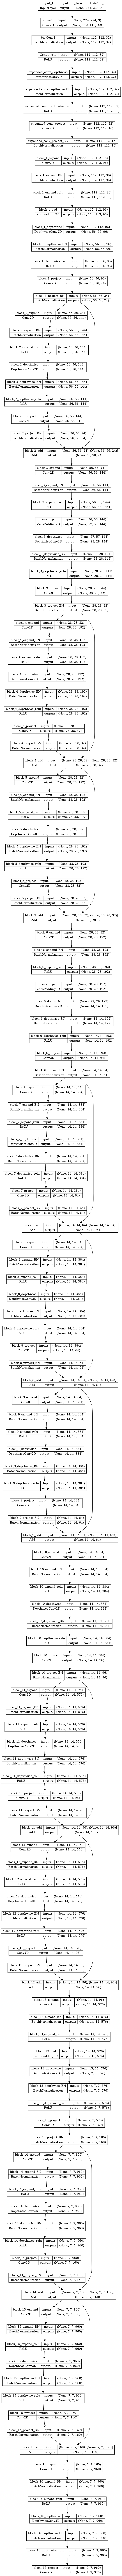

In [29]:
tf.keras.utils.plot_model(down_stack, show_shapes=True)

In [30]:

# Define each layer block for upbranch
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  #elif norm_type.lower() == 'instancenorm':
  #  result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [31]:
up_stack = [
    upsample(512, 3),  # 7x7 -> 14x14
    upsample(256, 3),  # 14x14 -> 28x28
    upsample(128, 3),  # 28x28 -> 56x56
    upsample(64, 3),   # 56x56 -> 112x112
]

In [32]:
for layer in trained_down_model.layers[1:4]:
    print(layer.name)

cropping2d
rescaling
conv2d


In [33]:
def unet_model(output_channels: int):

    # Add layers from classification model
    inputs = tf.keras.layers.Input(shape=[240, 240, 4])
    x = trained_down_model.layers[1](inputs)
    for layer in trained_down_model.layers[2:4]:
        x = layer(x)

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last_conv_trans = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding="same"
    )  # 64x64 -> 128x128

    x = last_conv_trans(x)

    x = tf.keras.layers.ZeroPadding2D(8)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [34]:
OUTPUT_CLASSES = 5
with strategy.scope():
    model = unet_model(output_channels=OUTPUT_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
    )

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 4  0           []                               
                                )]                                                                
                                                                                                  
 cropping2d (Cropping2D)        (None, 224, 224, 4)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 4)  0           ['cropping2d[1][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 3)  15          ['rescaling[1][0]']        

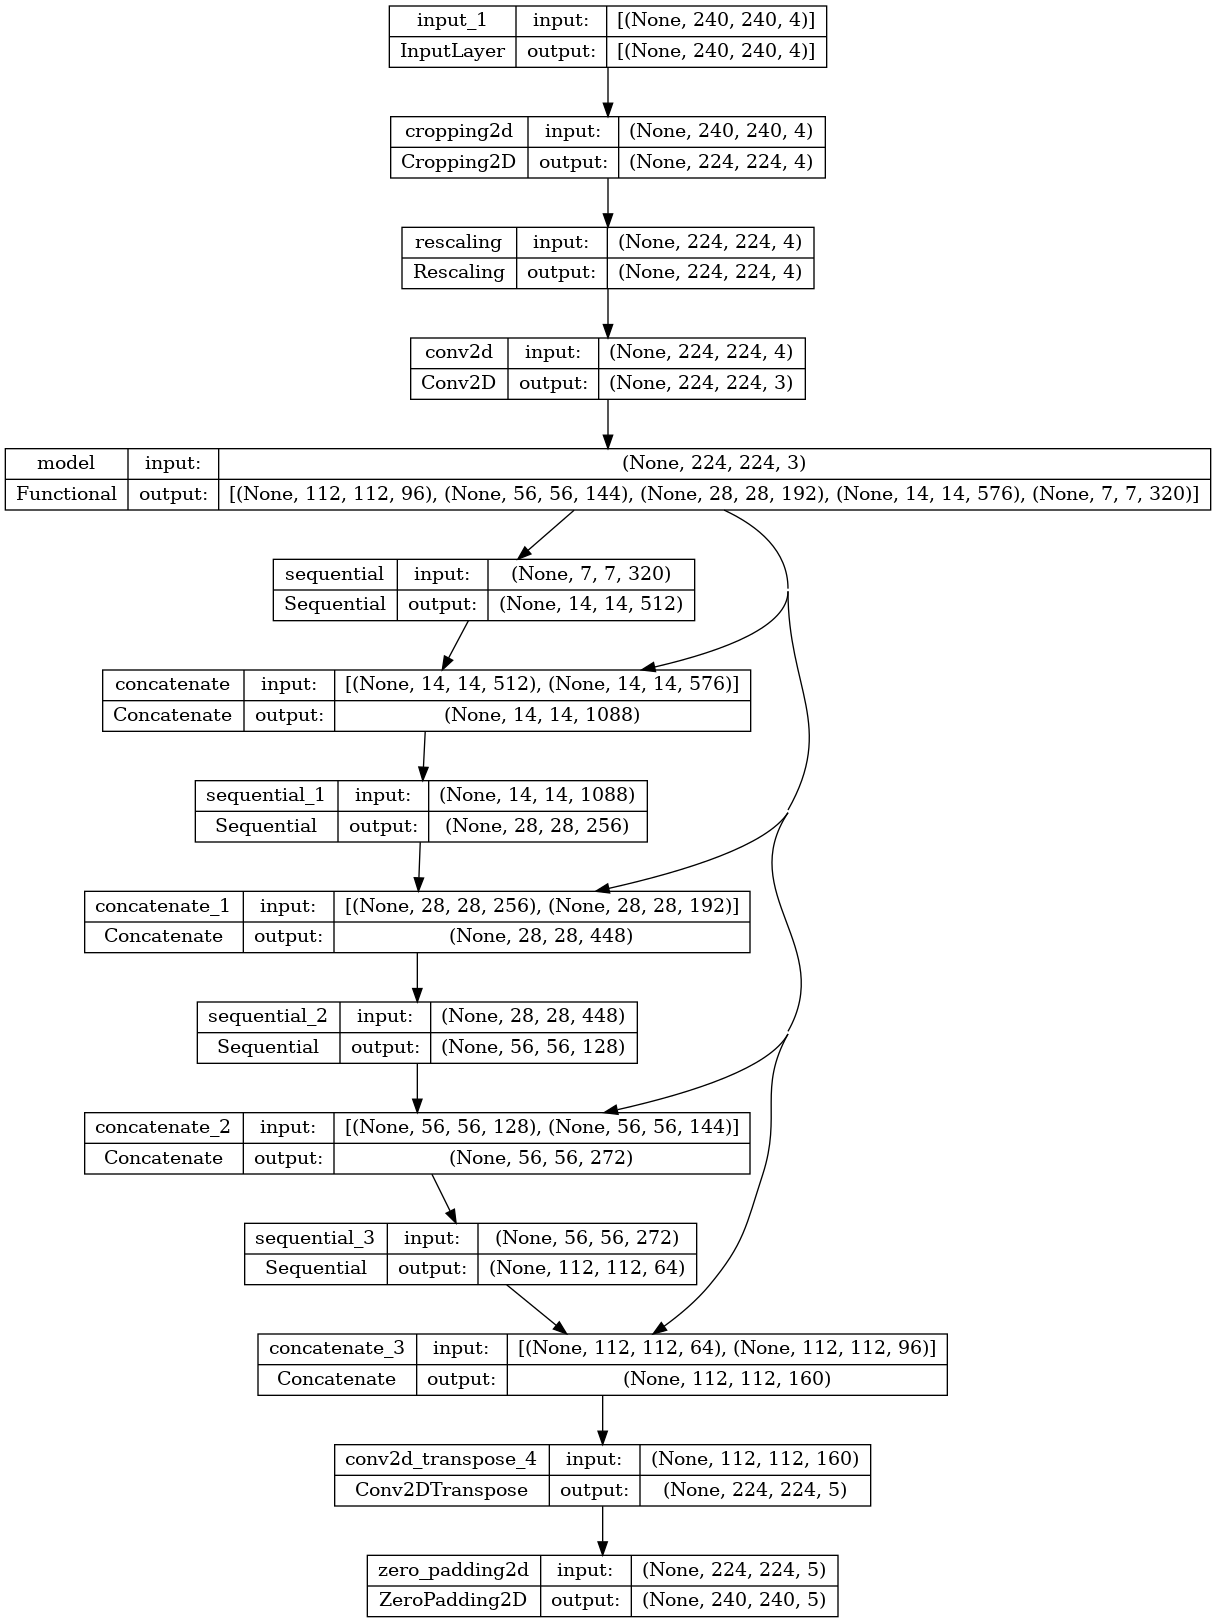

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [158]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap='terrain_r')
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [40]:
images = []
maps = []

train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy','train','map_data')

# Count pixels for sample weight
pixel_counts = [0,0,0,0,0]
for map_file in os.listdir(train_map_dir):

    seg_map = tf.io.read_file(os.path.join(train_map_dir,map_file))
    seg_map = tf.io.decode_png(seg_map, channels=1)
    
    indices,counts = np.unique(seg_map,return_counts=True)
    for i, index in enumerate(indices):
        pixel_counts[index] += counts[i]
print(pixel_counts)

[4085247787, 6097015, 29626584, 770604523, 9896091]


In [41]:
image_filenames = os.listdir(train_image_dir)
map_filenames = [filename.replace('allseq', 'map') for filename in image_filenames]
image_filepaths = [os.path.join(train_image_dir,filename) for filename in image_filenames]
map_filepaths = [os.path.join(train_map_dir,filename) for filename in map_filenames]

In [42]:
train_image_filepaths, val_image_filepaths, train_map_filepaths, val_map_filepaths = train_test_split(
    image_filepaths, 
    map_filepaths, 
    test_size=0.2,
    )
    

In [43]:
train_image_data = tf.data.Dataset.list_files(train_image_filepaths, shuffle=False)
train_map_data = tf.data.Dataset.list_files(train_map_filepaths, shuffle=False)
train_data = tf.data.Dataset.zip((train_image_data, train_map_data))
val_image_data = tf.data.Dataset.list_files(val_image_filepaths, shuffle=False)
val_map_data = tf.data.Dataset.list_files(val_map_filepaths, shuffle=False)
val_data = tf.data.Dataset.zip((val_image_data, val_map_data))

In [44]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def alter_segmap(x):
    return tf.where(x==4,tf.constant(3,dtype='uint8'),x)

def read_image_map(image, seg_map):
   image = tf.io.read_file(image)
   image = tf.io.decode_png(image, channels=4)
   seg_map = tf.io.read_file(seg_map)
   seg_map = tf.io.decode_png(seg_map, channels=1)
   # Change scaler below to scaler_0_1 to get initial values between 0 and 1
   return scaler_neg1_1(tf.cast(image, 'float32')) ,alter_segmap(seg_map)


In [134]:
train_batch = (
    train_data.cache()
    .shuffle(buffer_size)
    .map(read_image_map)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_batch = val_data.map(read_image_map).shuffle(buffer_size).batch(batch_size)

In [48]:
images, masks = next(iter(train_batch))

2022-12-02 15:51:34.315420: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


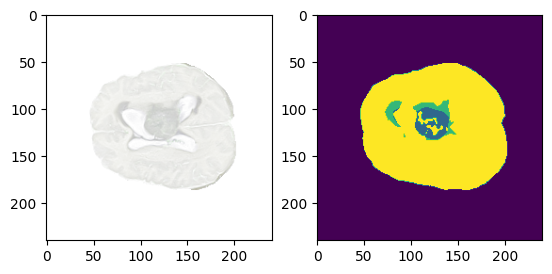

In [66]:
num = 20
fig, ax = plt.subplots(1,2)
ax[0].imshow(tf.cast(127.5*(images[num]+1), 'uint8'))
ax[1].imshow(masks[num])

In [67]:
val_images, val_masks = next(iter(train_batch))

2022-12-02 15:54:51.030910: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


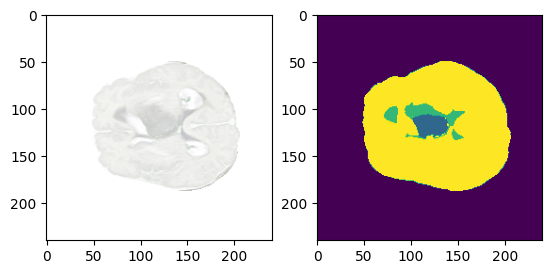

In [75]:
vnum = 7
fig, ax = plt.subplots(1,2)
ax[0].imshow(tf.cast(127.5*(val_images[vnum]+1), 'uint8'))
ax[1].imshow(val_masks[vnum])

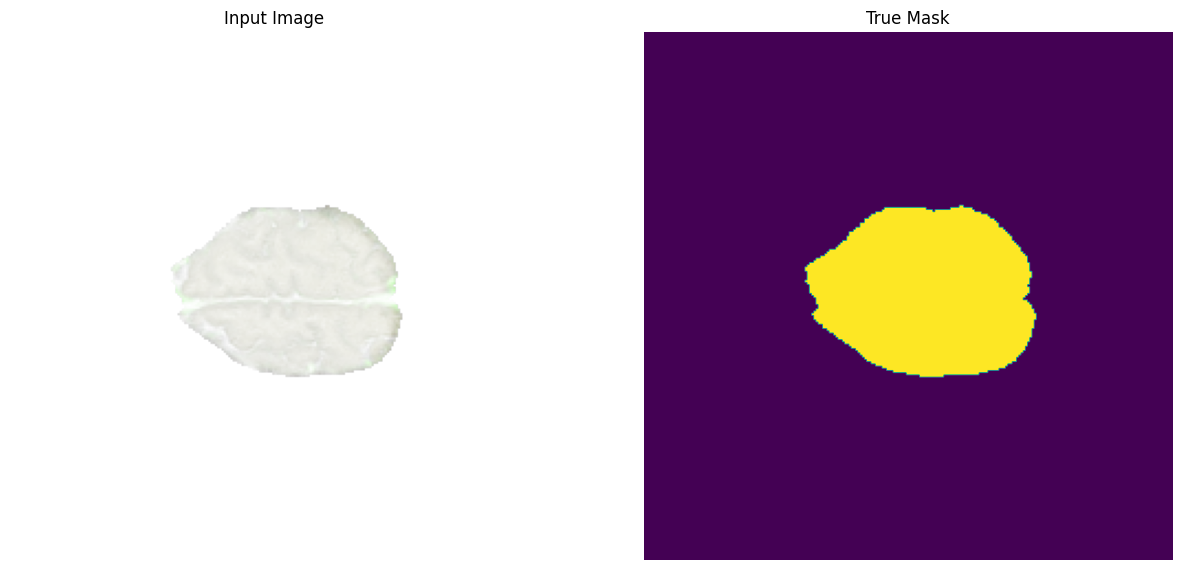

(64, 240, 240, 4) (64, 240, 240, 1)


2022-12-02 15:56:35.143406: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [76]:
for images, masks in train_batch.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
    print(images.shape, masks.shape)

1/1 [==============================] - 0s 489ms/step


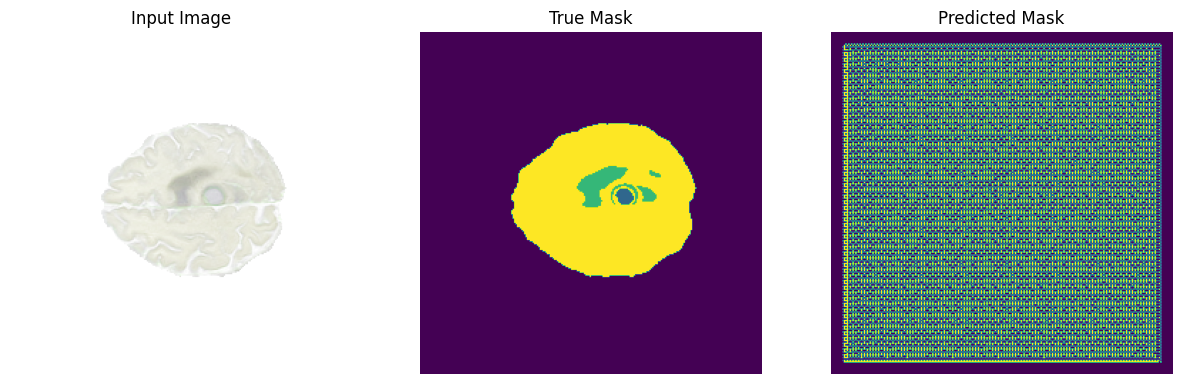

In [81]:
slice_num=3
sample_image, sample_mask = images[slice_num], masks[slice_num]
show_predictions()

In [82]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [83]:
# Calculate class weights
weights = 1.0/np.array(pixel_counts)
weights = weights/np.sum(weights)

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  #class_weights = tf.constant([2.0, 2.0, 1.0])
  #class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [84]:
weights

array([0.00081496, 0.54605922, 0.11237648, 0.00432041, 0.33642892])

In [85]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            )

In [86]:
print(len(train_image_filepaths),len(val_image_filepaths))

68076 17019


1/1 [==============================] - 0s 481ms/step


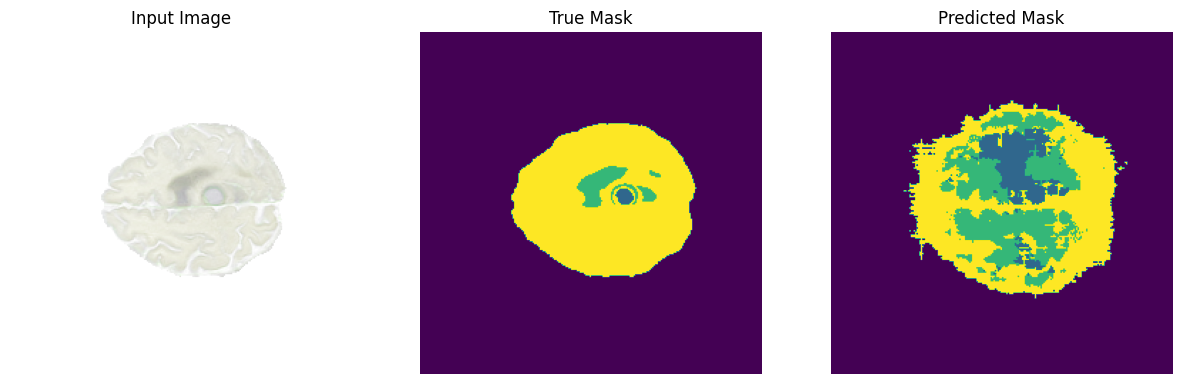


Sample Prediction after epoch 14

1063/1063 [==============================] - 232s 218ms/step - loss: 0.0018 - accuracy: 0.9065 - val_loss: 0.4689 - val_accuracy: 0.9015


In [88]:
#lr 0.0001
TRAIN_LENGTH=68076
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 17019//batch_size//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // batch_size

model_history = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

In [143]:
val_images, val_maps = next(iter(val_batch))

In [146]:
type(val_maps)

tensorflow.python.framework.ops.EagerTensor

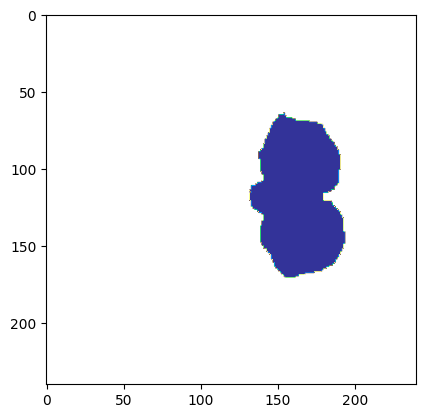

In [171]:
#val_maps.shape
plt.imshow(tf.cast(val_maps[48,:,:,0],'uint8'), cmap='terrain_r')

In [166]:
single_img = tf.expand_dims(val_images[57],0)
single_map = tf.expand_dims(val_maps[57],0)


In [167]:
single_ds = tf.data.Dataset.from_tensor_slices(([single_img],[single_map]))


1/1 [==============================] - 0s 493ms/step


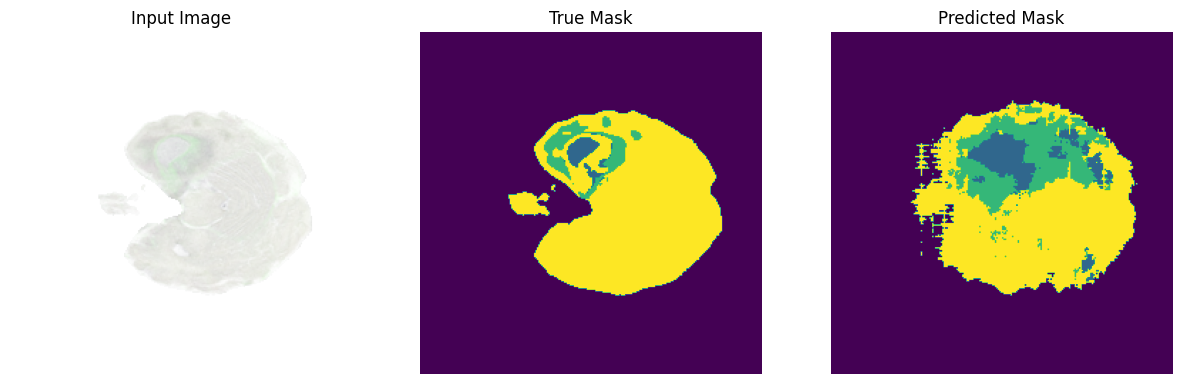

In [118]:
show_predictions(single_ds)

In [119]:
# Fully relax model
model.trainable = True

with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

1/1 [==============================] - 0s 490ms/step


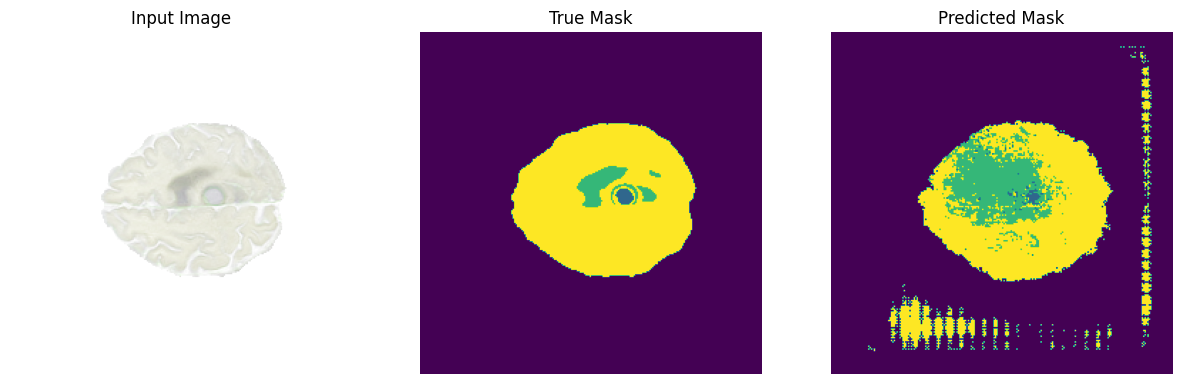


Sample Prediction after epoch 20

1063/1063 [==============================] - 254s 239ms/step - loss: 9.9042e-04 - accuracy: 0.9643 - val_loss: 0.4287 - val_accuracy: 0.9318


In [121]:
model_history_fullrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

1/1 [==============================] - 0s 491ms/step


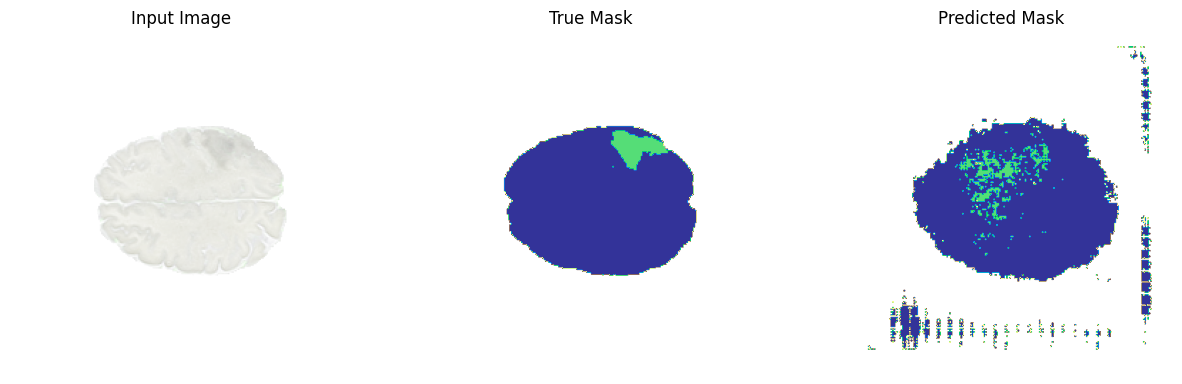

In [168]:
show_predictions(single_ds)